In [1]:
from __future__ import print_function

from keras.datasets import mnist
from keras.optimizers import RMSprop
from keras.utils import np_utils
from keras import objectives
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 784).astype('float32')
X_test = X_test.reshape(10000, 784).astype('float32')
X_train /= 255.0
X_test /= 255.0

# convert class vectors to 1-of-K format
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [3]:
print('train samples: ', X_train.shape)
print('test samples: ', X_test.shape)

train samples:  (60000, 784)
test samples:  (10000, 784)


## Variational AutoEncoder

In [4]:
nb_epoch=100
batch_size=50
z_dim =2
epsilon_std = 0.01

In [5]:
x = Input(shape=(784,))
hidden = Dense(500, activation='relu')(x)
z_mean = Dense(z_dim)(hidden)
z_log_sigma = Dense(z_dim)(hidden)

In [6]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(z_dim,), mean=0., std=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon

In [7]:
z = Lambda(sampling, output_shape=(z_dim,))([z_mean, z_log_sigma])

In [8]:
decoder_h = Dense(128, activation='relu')
decoder_mean = Dense(784, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [9]:
def vae_loss(x, x_decoded_mean):
    reconst_loss = objectives.binary_crossentropy(x, x_decoded_mean)
    latent_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return reconst_loss + latent_loss

In [10]:
# end-to-end autoencoder
vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss)

# encoder, from inputs to latent space
encoder = Model(x, z_mean)

In [11]:
z_in = Input(shape=(z_dim,))
_h_decoded = decoder_h(z_in)
_x_decoded_mean = decoder_mean(_h_decoded)

In [12]:
decoder= Model(input=z_in, output=_x_decoded_mean)

In [13]:
hist_vae = vae.fit(X_train, X_train,
        nb_epoch=nb_epoch,
        batch_size=batch_size,
        shuffle = True,
        validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 42s - loss: 0.2803 - val_loss: 0.2400
Epoch 2/100
60000/60000 [==============================] - 41s - loss: 0.2331 - val_loss: 0.2269
Epoch 3/100
60000/60000 [==============================] - 44s - loss: 0.2253 - val_loss: 0.2219
Epoch 4/100
60000/60000 [==============================] - 41s - loss: 0.2216 - val_loss: 0.2198
Epoch 5/100
60000/60000 [==============================] - 45s - loss: 0.2187 - val_loss: 0.2162
Epoch 6/100
60000/60000 [==============================] - 40s - loss: 0.2166 - val_loss: 0.2144
Epoch 7/100
60000/60000 [==============================] - 44s - loss: 0.2148 - val_loss: 0.2126
Epoch 8/100
60000/60000 [==============================] - 41s - loss: 0.2137 - val_loss: 0.2121
Epoch 9/100
60000/60000 [==============================] - 40s - loss: 0.2129 - val_loss: 0.2122
Epoch 10/100
60000/60000 [==============================] - 41s - loss: 0.212

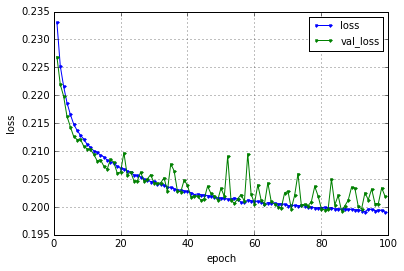

In [14]:
# plot loss
loss = hist_vae.history['loss']
val_loss = hist_vae.history['val_loss']

plt.plot(range(1,nb_epoch), loss[1:], marker='.', label='loss')
plt.plot(range(1,nb_epoch), val_loss[1:], marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

/Users/sho/.pyenv/versions/anaconda-2.4.0/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


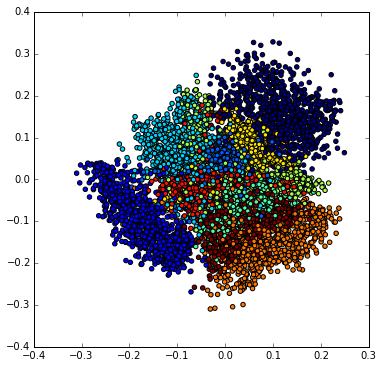

In [15]:
X_test_encoded = encoder.predict(X_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(X_test_encoded[:,0],X_test_encoded[:,1], c=np.argmax(y_test,axis=1))
plt.show()

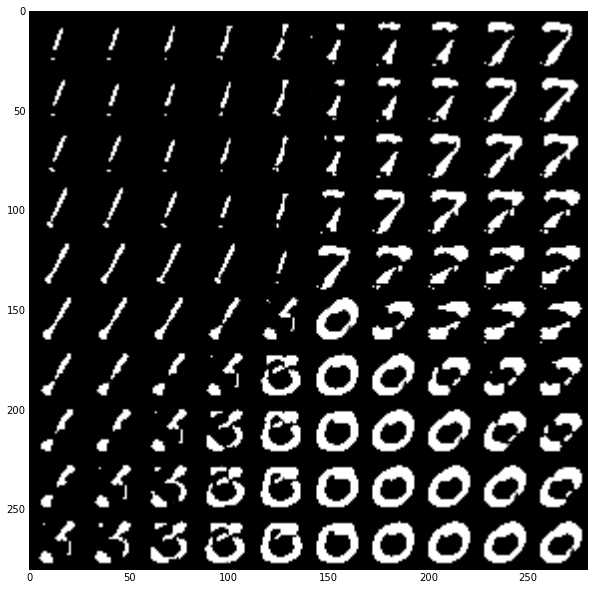

In [16]:
n = 10  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='gray')
plt.show()